In [4]:
import pandas as pd
import numpy as np
import os
import math
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import StratifiedShuffleSplit


# SMOTE stuff
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from numpy import where
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [8]:
#Separating the test days from normal ones
rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
os.chdir(rootAddressAllData)
testDays=np.array([[datetime(2018,7,20),datetime(2018,7,13),datetime(2018,7,27),datetime(2018,7,10),datetime(2018,6,22),datetime(2018,7,3),datetime(2018,7,17),datetime(2018,6,25),datetime(2018,7,24)],
           [datetime(2018,7,19),datetime(2018,6,28),datetime(2018,7,20),datetime(2018,7,27),datetime(2018,7,3),datetime(2018,6,22),datetime(2018,7,26),datetime(2018,6,29),datetime(2018,7,13)],
           [datetime(2018,8,16),datetime(2018,8,8),datetime(2018,8,10),datetime(2018,7,30),datetime(2018,8,20),datetime(2018,8,3),datetime(2018,8,1),datetime(2018,8,17),datetime(2018,8,15)],
           [datetime(2018,8,28),datetime(2018,8,15),datetime(2018,8,14),datetime(2018,8,29),datetime(2018,8,20),datetime(2018,8,22),datetime(2018,8,27),datetime(2018,8,21),datetime(2018,8,16)],
           [datetime(2018,9,4),datetime(2018,9,5),datetime(2018,9,6),datetime(2018,9,11),datetime(2018,9,13),datetime(2018,9,14),datetime(2018,9,17),datetime(2018,9,18),datetime(2018,9,20)],
           [datetime(2018,9,13),datetime(2018,9,14),datetime(2018,9,17),datetime(2018,9,18),datetime(2018,9,25),datetime(2018,9,26),datetime(2018,9,27),datetime(2018,10,2),datetime(2018,10,3)],    
           [datetime(2018,9,25),datetime(2018,9,26),datetime(2018,9,27),datetime(2018,10,2),datetime(2018,10,3),datetime(2018,10,4),datetime(2018,10,9),datetime(2018,10,10),datetime(2018,10,11)]
           ]).astype(datetime)

patientName=['38A','38B','38C','38D','38E','38F','38H']

myFiles=os.listdir()

for myFile in myFiles:
    for counter in range(0,7):
        if(patientName[counter] in myFile):
            currentPatient=counter
            break    
    testDayCounter=1
    print(myFile)
    myDf=pd.read_csv(myFile)
    for myColumn in myDf.columns: 
        if myColumn not in ['time','BG','Participant']:
            del myDf[myColumn]
    myDf=myDf.dropna()
    myDf=myDf.drop_duplicates(subset=['time'], keep='last')
    myDf['time']= pd.to_datetime(myDf['time'])
        
    myDf.insert(3,"StandardTest",0)
    for rowCounter in range(0,len(myDf)):
        for counter in range(0,9):
            if myDf.iloc[rowCounter,1].date()==testDays[currentPatient][counter].date():
                myDf.iloc[rowCounter,3]=counter+1
                break
    myDf=myDf[myDf.StandardTest > 0]
    myFileAddress=rootAddressSanitized+patientName[currentPatient]+'.csv'
    myDf.to_csv(myFileAddress,index = False)

overall_spread_sheet_38A.csv
overall_spread_sheet_38B.csv
overall_spread_sheet_38C.csv
overall_spread_sheet_38D.csv
overall_spread_sheet_38E.csv
overall_spread_sheet_38F.csv
overall_spread_sheet_38H.csv


In [16]:
#Running the Random Forest and XGBoost functions
#This is the older version of the Algorithm which uses time window rather than point number
def STMI_random_forest(trains_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_tree_number=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for threshold_counter in np.arange(0.4,0.8,0.2):
        threshold_counter=round(threshold_counter,2)
        for tree_number_counter in np.arange(3,10):
            for max_depth_counter in np.arange(3,10):
                for positive_weight_counter in np.arange(1,4,0.5):
                    treeNumber=tree_number_counter
                    maxDepth=max_depth_counter
                    positive_weight=0.2*10**positive_weight_counter

                    clf=RandomForestClassifier(n_estimators=treeNumber,criterion='entropy',random_state=0,max_depth=maxDepth,class_weight={0: 1, 1: positive_weight})
                    clf.fit(trains_data_func,train_labels_func)
                    sliddingWindowPrediction=clf.predict_proba(test_data_func)
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold_counter]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold_counter]=0

                    confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction);
                    accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction);
                    recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction);            

                    if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                        best_accuracy=accuracy_score_value;
                        best_recall=recall_score_value;
                        best_tree_number=treeNumber;
                        best_positive_weight=positive_weight;
                        best_max_depth=maxDepth;                
                        best_confusion_matrix=confusionMatrix;
                        best_threshold=threshold_counter

    best_confusion_matrix=[['\t\t','Pred Neg\t','Pred Pos'],['True Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['True Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\RF"+patient_name_func+".pkl"
    pickle.dump(clf, open(file_name, "wb"))    
    return best_threshold,best_tree_number,best_max_depth,best_positive_weight,best_accuracy,best_recall,best_confusion_matrix;


def STMI_XGBoost(train_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_eta=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for threshold_counter in np.arange(0.4,0.8,0.2):
        threshold_counter=round(threshold_counter,2)
        for eta_counter in np.arange(0.05,0.50,0.05):
            for max_depth_counter in np.arange(3,10):
                for positive_weight_counter in np.arange(1,4,0.5):
                    eta_value=eta_counter;
                    maxDepth=max_depth_counter;
                    positive_weight=0.2*10**positive_weight_counter;

                    model = XGBClassifier(eta=eta_value,max_depth=maxDepth,scale_pos_weight=positive_weight,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False);
                    model.fit(train_data_func, train_labels_func);
                    sliddingWindowPrediction = model.predict_proba(test_data_func);
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold_counter]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold_counter]=0

                    confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction);
                    accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction);
                    recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction);     

                    if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                        best_accuracy=accuracy_score_value;
                        best_recall=recall_score_value;
                        best_eta=eta_value;
                        best_positive_weight=positive_weight;
                        best_max_depth=maxDepth;                
                        best_confusion_matrix=confusionMatrix; 
                        best_threshold=threshold_counter
        
    best_confusion_matrix=[['\t\t','Pred Neg\t','Pred Pos'],['True Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['True Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\XG"+patient_name_func+".pkl"
    pickle.dump(model, open(file_name, "wb"))    
    return best_threshold,best_eta,best_max_depth,best_positive_weight,best_accuracy,best_recall,best_confusion_matrix;


rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
os.chdir(rootAddress)
timeWindow=120;
timeStep=60;
breakfastTime=datetime(2020,1,1,8,0)
myFiles=os.listdir()

for myFile in myFiles:
    if('.pkl' in myFile):
        continue;
    print('Reading.....',myFile)
    fileAddress=myFile
    if (myFile=='TestDays_38F.csv'):
        print("=================Patient F is discarded===============");
        continue;
    sliddingWindow=[]
    sliddingWindowResult=[]

    raw1=pd.read_csv(fileAddress) 
    raw1['time']= pd.to_datetime(raw1['time'])
    raw1=raw1.dropna()
    raw1=raw1.drop_duplicates(subset=['time'], keep='last')

    startTime=raw1.iloc[0,1]
    endTime=startTime+timedelta(minutes = timeWindow)
    counter=0;
    baseLine=-10;

    while(True):
        #Establishing the base line between 6 and 8 AM of every day
        baseLineQuery=raw1[raw1.time.dt.month==startTime.month];
        baseLineQuery=baseLineQuery[baseLineQuery.time.dt.day==startTime.day];
        baseLineQuery=baseLineQuery[baseLineQuery.time.dt.hour>=6];
        baseLineQuery=baseLineQuery[baseLineQuery.time.dt.hour<8];
        if(not np.isnan(baseLineQuery.BG.mean())):
           baseLine=baseLineQuery.BG.mean()
        else:
            newQuery=raw1
            newQuery=newQuery[newQuery.time.dt.month==startTime.month]
            newQuery=newQuery[newQuery.time.dt.day==startTime.day]
            if(not np.isnan(newQuery.BG.mean())):
                print("The BG base line is not found for the following date",startTime.year,startTime.month,startTime.day)
        if (raw1.iloc[-1,1]<endTime):
            break
        myQuery=raw1[raw1.time >= startTime]
        myQuery=myQuery[myQuery.time <= endTime]
           
        if (len(myQuery)<=1):
            startTime+=timedelta(minutes=timeStep)
            endTime+=timedelta(minutes=timeStep)
            continue

        if(startTime.time()<=breakfastTime.time() and endTime.time()>=breakfastTime.time()):
            eatFlag=1
        else:
            eatFlag=0
            
        integralValue=0
        maxSlope=0
        for counter in range(0,len(myQuery)-1):
            timeSpanTemp=myQuery.iloc[counter+1,1]-myQuery.iloc[counter,1]
            timeSpanTemp=timeSpanTemp.total_seconds()
            if(timeSpanTemp==0):
                print(startTime,endTime)
                continue;
            integralValue+=timeSpanTemp*((myQuery.iloc[counter+1,2]+myQuery.iloc[counter,2])/2-baseLine)
            currentSlope=(myQuery.iloc[counter+1,2]-myQuery.iloc[counter,2])/timeSpanTemp
            currentSlope=abs(currentSlope)
            if(currentSlope>maxSlope):
                maxSlope=currentSlope
        patientName=myQuery.iloc[0,0]
        meanValue=round(myQuery['BG'].mean()-baseLine,2)
        stdValue=round(myQuery['BG'].std(),2)
        minValue=round(myQuery['BG'].min()-baseLine,2)
        maxValue=round(myQuery['BG'].max()-baseLine,2)
        slopeValue=round(maxSlope,2)
        intValue=round(integralValue,2)
        
        sliddingWindow.append([meanValue,stdValue,minValue,maxValue,slopeValue,intValue,baseLine,patientName,startTime,endTime])

        sliddingWindowResult.append(eatFlag);
        startTime+=timedelta(minutes=timeStep);
        endTime+=timedelta(minutes=timeStep);

    sliddingWindow=np.array(sliddingWindow);
    sliddingWindow=sliddingWindow[:,0:6]#dropping baseline, patientname, starttime and endtime    

    sliddingWindowResult=np.array(sliddingWindowResult);
    balancedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.4)

    for train_index, test_index in balancedSplit.split(sliddingWindow, sliddingWindowResult):
        train_data, test_data = sliddingWindow[train_index], sliddingWindow[test_index]
        train_labels, test_labels = sliddingWindowResult[train_index], sliddingWindowResult[test_index]
    
    RF_best_threshold,RF_best_tree_number,RF_best_max_depth,RF_best_positive_weight,RF_best_accuracy,RF_best_recall,RF_best_confusion_matrix=STMI_random_forest(train_data,test_data,train_labels,test_labels,patientName);
    print("Patient=",myFile,"best class prediction threshold=",RF_best_threshold,"best tree number=",RF_best_tree_number,"best max depth=",RF_best_max_depth,"best positive weight=",round(RF_best_positive_weight,2),"best accuracy=",round(RF_best_accuracy,2),"best recall=",round(RF_best_recall,2))
    print("\n")
    for r in RF_best_confusion_matrix:
        for c in r:
            print(c,end = " ")
        print("\n")
    
#     XG_best_threshold,XG_best_eta,XG_best_max_depth,XG_best_positive_weight,XG_best_accuracy,XG_best_recall,XG_best_confusion_matrix=STMI_XGBoost(train_data,test_data,train_labels,test_labels,myFile[myFile.index('_')+1:myFile.index('.')]);
#     print("Patient=",myFile,"best class prediction threshold=",XG_best_threshold,"best eta=",XG_best_eta,"best max depth=",XG_best_max_depth,"best positive weight=",round(XG_best_positive_weight,2),"best accuracy=",round(XG_best_accuracy,2),"best recall=",round(XG_best_recall,2))
#     print("\n")
#     for r in XG_best_confusion_matrix:
#         for c in r:
#             print(c,end = " ")
#         print("\n")


Reading..... TestDays_38A.csv
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not found for the following date 2018 6 25
The BG base line is not f

In [21]:
#Running the Random Forest and XGBoost functions
#The time windows is based on the number of points rather than actual time
def STMI_random_forest(trains_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_tree_number=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for tree_number_counter in np.arange(3,10):
        for max_depth_counter in np.arange(3,10):
            for positive_weight_counter in np.arange(1,4,0.5):
                treeNumber=tree_number_counter;
                maxDepth=max_depth_counter;
                positive_weight=0.2*10**positive_weight_counter;

                clf=RandomForestClassifier(n_estimators=treeNumber,criterion='entropy',random_state=0,max_depth=maxDepth,class_weight={0: 1, 1: positive_weight});
                clf.fit(trains_data_func,train_labels_func);
                sliddingWindowPrediction=clf.predict(test_data_func);

                confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction);
                accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction);
                recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction);            

                if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                    best_accuracy=accuracy_score_value;
                    best_recall=recall_score_value;
                    best_tree_number=treeNumber;
                    best_positive_weight=positive_weight;
                    best_max_depth=maxDepth;                
                    best_confusion_matrix=confusionMatrix;
    best_confusion_matrix=[['\t\t','Pred Neg\t','Pred Pos'],['True Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['True Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\RF"+patient_name_func+".pkl"
    pickle.dump(clf, open(file_name, "wb"))    
    return best_tree_number,best_max_depth,best_positive_weight,best_accuracy,best_recall,best_confusion_matrix;


def STMI_XGBoost(train_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_eta=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for eta_counter in np.arange(0.05,0.50,0.05):
        for max_depth_counter in np.arange(3,10):
            for positive_weight_counter in np.arange(1,4,0.5):
                eta_value=eta_counter;
                maxDepth=max_depth_counter;
                positive_weight=0.2*10**positive_weight_counter;

                model = XGBClassifier(eta=eta_value,max_depth=maxDepth,scale_pos_weight=positive_weight,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False);
                model.fit(train_data_func, train_labels_func);
                sliddingWindowPrediction = model.predict(test_data_func);

                confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction);
                accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction);
                recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction);     

                if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                    best_accuracy=accuracy_score_value;
                    best_recall=recall_score_value;
                    best_eta=eta_value;
                    best_positive_weight=positive_weight;
                    best_max_depth=maxDepth;                
                    best_confusion_matrix=confusionMatrix;   

    best_confusion_matrix=[['\t\t','Pred Neg\t','Pred Pos'],['True Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['True Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\XG"+patient_name_func+".pkl"
    pickle.dump(model, open(file_name, "wb"))    
    return best_eta,best_max_depth,best_positive_weight,best_accuracy,best_recall,best_confusion_matrix;


rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
os.chdir(rootAddress)
windowPointNumber=8
sliddingPointNumber=4

breakfastTime=datetime(2020,1,1,8,0)
myFiles=os.listdir()

for myFile in myFiles:
    if('.csv' not in myFile):
        continue;
    print('Reading.....',myFile)
    fileAddress=myFile
#     if (myFile!='TestDays_38F.csv'):
#         print("=================Patient F is discarded===============");
#         continue;
    sliddingWindow=[]
    sliddingWindowResult=[]

    rawData=pd.read_csv(fileAddress) 
    rawData['time']= pd.to_datetime(rawData['time'])
    rawData=rawData.dropna()
    rawData=rawData.drop_duplicates(subset=['time'], keep='last')
    wholeTime= pd.to_datetime(rawData['time'])

    startPoint=0
    endPoint=windowPointNumber-1
    baseLine=-10;
    while(True):
        if endPoint>=len(rawData):#end of the file
            break
#         print(startPoint,endPoint, len(rawData))
        if rawData.iloc[startPoint,1].date()!=rawData.iloc[endPoint,1].date():#the reading is not in the same date
            startPoint+=sliddingPointNumber
            endPoint+=sliddingPointNumber
            continue       
            
        #Establishing the base line between 6 and 8 AM of every day
        baseLineQuery=rawData[rawData.time.dt.month==wholeTime[startPoint].month]
        baseLineQuery=baseLineQuery[baseLineQuery.time.dt.day==wholeTime[startPoint].day]
        
        baseLineReserved=baseLineQuery.BG.min()
        baseLineReservedDate=baseLineQuery.iloc[0,1].date()
        
        baseLineQuery=baseLineQuery[baseLineQuery.time.dt.hour>=6]
        baseLineQuery=baseLineQuery[baseLineQuery.time.dt.hour<8]
        if(not np.isnan(baseLineQuery.BG.mean())):
           baseLine=baseLineQuery.BG.mean()
        else:
            print("The BG base line is not found for the following date:",baseLineReservedDate,baseLineReserved)
            baseLine=baseLineReserved #the baseline is not found and it is replaced by the minimum BG
        myQuery=rawData.iloc[startPoint:endPoint,:]
        if(myQuery.iloc[0,1].time()<breakfastTime.time() and myQuery.iloc[-1,1].time()>breakfastTime.time()):
            eatFlag=1
        else:
            eatFlag=0

        readingData=myQuery['BG'];
        readingData=readingData.values;
        readingData=np.diff(readingData)
        sliddingWindow.append(readingData);
        sliddingWindowResult.append(eatFlag);
        startPoint+=sliddingPointNumber;
        endPoint+=sliddingPointNumber;

    sliddingWindow=np.array(sliddingWindow);
    sliddingWindow=np.squeeze(sliddingWindow);
    
    sliddingWindowResult=np.array(sliddingWindowResult);
    sliddingWindowResult=sliddingWindowResult.ravel();
    
    train_data,test_data,train_labels,test_labels=train_test_split(sliddingWindow,sliddingWindowResult,test_size=0.5,random_state=0,shuffle=True);

    
    RF_best_tree_number,RF_best_max_depth,RF_best_positive_weight,RF_best_accuracy,RF_best_recall,RF_best_confusion_matrix=STMI_random_forest(train_data,test_data,train_labels,test_labels,myFile[myFile.index('_')+1:myFile.index('.')]);    
    print("Patient=",myFile,"best tree number=",RF_best_tree_number,"best max depth=",RF_best_max_depth,"best positive weight=",round(RF_best_positive_weight,2),"best accuracy=",round(RF_best_accuracy,2),"best recall=",round(RF_best_recall,2))
    print("\n")
    for r in RF_best_confusion_matrix:
        for c in r:
            print(c,end = " ")
        print("\n")

#     XG_best_eta,XG_best_max_depth,XG_best_positive_weight,XG_best_accuracy,XG_best_recall,XG_best_confusion_matrix=STMI_XGBoost(train_data,test_data,train_labels,test_labels,myFile[myFile.index('_')+1:myFile.index('.')]);
#     print("Patient=",myFile,"best eta=",XG_best_eta,"best max depth=",XG_best_max_depth,"best positive weight=",round(XG_best_positive_weight,2),"best accuracy=",round(XG_best_accuracy,2),"best recall=",round(XG_best_recall,2))
#     print("\n")
#     for r in XG_best_confusion_matrix:
#         for c in r:
#             print(c,end = " ")
#         print("\n")


Reading..... TestDays_38A.csv
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
The BG base line is not found for the following date: 2018-06-25 47.0
Patient= TestDays_38A.csv best tree number= 3 best max depth

In [23]:
import statsmodels.api as sm

model=sm.OLS(sliddingWindowResult_train,sliddingWindow_train)
results=model.fit()
results.summary()

NameError: name 'sliddingWindowResult_train' is not defined

Counter({0: 9900, 1: 100})
Mean ROC AUC: 0.886
Counter({0: 9900, 1: 9900})
Mean ROC AUC: 0.988


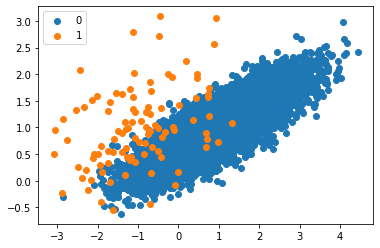

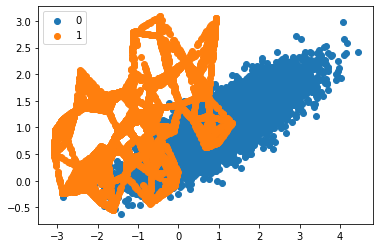

In [5]:
# %% SMOTE
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
counter = Counter(y)
print(counter)
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()
# define model
model = RandomForestClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))